#  Исследование результатов А/В-теста и поиск инсайтов

SollmaFin — международное мобильное приложение для онлайн-торговли финансовыми активами. Пользователи могут инвестировать деньги в акции, валюту, криптовалюту, биржевые фонды (ETF) и другие активы. Целевая аудитория приложения — начинающие инвесторы. Получить доступ к финансовым рынкам можно со смартфона либо через веб-версию. 

Приложение ориентировано на рынок Латинской Америки с акцентом на четыре страны: Мексику, Бразилию, Колумбию и Аргентину — там быстро растёт интерес к финтеху и инвестициям, а экономики очень разные. 

Появилась гипотеза о недостаточной финансовой грамотности пользователей: они не понимают, как работать с активами разной степени риска. Клиенты покупают активы с высоким риском и теряют деньги, что снижает вовлечённость.
Команда продукта решила обновить онбординг пользователей и добавить в него детальную информацию о различиях финансовых активов и связанных с ними рисках. Однако появилось опасение, что углублённый онбординг отпугнёт клиентов от пополнения депозита и более рискованных вложений. 

### А/В-эксперимент

В эксперименте участвовали новые пользователи, которые зарегистрировались в приложении со 2 по 15 июня 2025 года. 
Пользователей случайным образом разделили на две равные группы: 
- Контрольная группа проходила стандартный онбординг без обязательного обучения.
- Тестовая группа проходила обновлённый онбординг с подробной информацией об активах и связанных с ними рисках. 

После разделения активность пользователей анализировали в течение недели.

**Цель эксперимента — оценить, как обновлённый онбординг влияет на поведение пользователей и их дальнейшую инвестиционную активность.**

Чтобы увидеть полную картину будем следить за таким набор метрик: 
- Ключевая метрика — средняя сумма всех депозитов на одного пользователя (включая тех, кто установил приложение или открыл веб-версию).
- Барьерная метрика — конверсия из регистрации в первый депозит.
- Вспомогательная метрика 1 — конверсия из первого депозита во второй.
- Вспомогательная метрика 2 — средняя сумма всех депозитов на пользователя, который открыл хотя бы один депозит.

Ожидается, что ключевая и барьерная метрики не упадут, а вспомогательные покажут значительный рост. 

### Данные

1. Датасет `/datasets/pa_sollmafin_hist.csv` содержит исторические данные о ключевых действиях новых пользователей, привлечённых в период с 1 апреля по 1 июня 2025 года включительно. В датасете собраны действия пользователей до оформления второго депозита. 
2. Датасет `/datasets/pa_sollmafin_abt.csv` содержит данные А/В-эксперимента — все действия новых пользователей, которые зарегистрировались со 2 по 15 июня 2025 года включительно. Данные собраны в рамках проверки гипотезы о влиянии нового онбординга на поведение и активность пользователей. Пользователи уже распределены по группам А/В-эксперимента.

Общие поля датасетов:
- `user_id` — уникальный идентификатор пользователя;
- `country_code` — код страны пользователя в формате ISO (например, `BR` — Бразилия, `MX` — Мексика, `AR` — Аргентина, `CO` — Колумбия);
- `platform` — устройство, с которого пользователь взаимодействует с продуктом: mobile или web;
- `first_ts` — время первого появления пользователя в системе;
- `first_dt` — дата первого появления пользователя (без времени);
- `event_ts` — время события;
- `event_name` — название события;
- `amount` — сумма пополнения депозита;
- `asset` — тип приобретённого актива; 
- `risk_level` — уровень риска актива: low — низкий риск, medium — средний риск, high — высокий риск.

В датасете `/datasets/pa_sollmafin_abt.csv` содержатся два дополнительных поля:
- `ab_test` — название А/В-эксперимента;
- `group` — пользовательская группа А/В-эксперимента.


### План проекта
1. Загрузка исторических данных и их предобработка
2. Исследовательский анализ исторических данных
3. Исследование результатов А/В эксперимента
4. Анализ изменений суммы депозитов на платящего пользователя
5. Выводы

---

## Часть 1

### 1. Загрузка исторических данных и их предобработка

In [3]:
# Загружаем библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [4]:
# Выгружаем данные 
sollmafin_hist = pd.read_csv('https://code.s3.yandex.net/datasets/pa_sollmafin_hist.csv')

In [5]:
# Фильтруем данные по дате
sollmafin_hist = sollmafin_hist[(sollmafin_hist['first_dt'] >= '2025-04-01') & (sollmafin_hist['first_dt'] <= '2025-06-01')]

In [6]:
sollmafin_hist.head()

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
0,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:51,install / open_web,NaN,NaN,NaN
1,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:59,introduction,NaN,NaN,NaN
2,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:06,registration,NaN,NaN,NaN
3,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:15,main_page,NaN,NaN,NaN
4,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:47:59,onboarding_complete,NaN,NaN,NaN


In [7]:
sollmafin_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238059 entries, 0 to 238058
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       238059 non-null  object 
 1   country_code  238059 non-null  object 
 2   platform      238059 non-null  object 
 3   first_ts      238059 non-null  object 
 4   first_dt      238059 non-null  object 
 5   event_ts      238059 non-null  object 
 6   event_name    238059 non-null  object 
 7   amount        33093 non-null   float64
 8   asset         15392 non-null   object 
 9   risk_level    15392 non-null   object 
dtypes: float64(1), object(9)
memory usage: 18.2+ MB


In [8]:
# Преобразуем даты в формат datetime
sollmafin_hist['first_ts'] = pd.to_datetime(sollmafin_hist['first_ts'])
sollmafin_hist['first_dt'] = pd.to_datetime(sollmafin_hist['first_dt'])
sollmafin_hist['event_ts'] = pd.to_datetime(sollmafin_hist['event_ts'])

In [9]:
# Поиск явных дубликатов
print(sollmafin_hist.duplicated().sum())

0


In [10]:
# Проверим данные на дубликаты по id пользователя, дате и названия события
sollmafin_hist[['user_id','event_ts','event_name']].duplicated().sum()

0

In [11]:
sollmafin_hist['event_name'].unique()

array(['install / open_web', 'introduction', 'registration', 'main_page',
       'onboarding_complete', 'first_deposit', 'asset_purchase',
       'second_deposit'], dtype=object)

In [12]:
sollmafin_hist['platform'].unique()

array(['mobile', 'web'], dtype=object)

In [13]:
sollmafin_hist['country_code'].unique()

array(['BR', 'AR', 'CO', 'MX'], dtype=object)

In [14]:
# Сначала фильтруем только события с пополнением (amount > 0)
deposits = sollmafin_hist[sollmafin_hist['amount'] > 0]['amount']

In [15]:
# Основные статистики
print(deposits.describe())

count    33093.000000
mean       113.527967
std         34.472458
min         27.000000
25%         90.000000
50%        109.000000
75%        131.000000
max        524.000000
Name: amount, dtype: float64


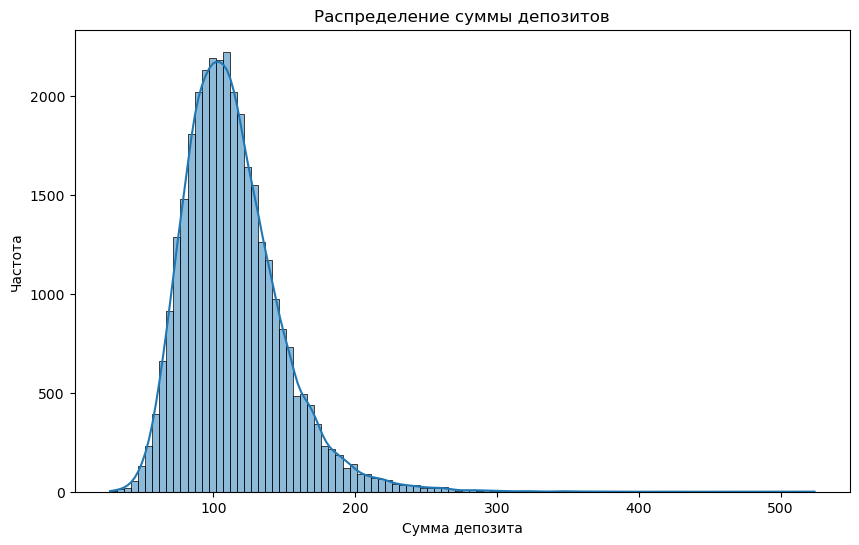

In [16]:
# Визуализация распределения суммы депозитов
plt.figure(figsize=(10,6))
sns.histplot(deposits, bins=100, kde=True)
plt.title('Распределение суммы депозитов')
plt.xlabel('Сумма депозита')
plt.ylabel('Частота')
plt.show()

Преобразовали столбцы с датами в формат datetime, явных дубликатов не найдено. Пропуски оставили, так как не все пользователи открывали депозиты. Распределение депозитов сильно скошено вправо: есть выбросы с высокими суммами, что может влиять на средние значения.

---

### 2. Исследовательский анализ исторических данных

**Задача 2.1.** Анализ новых пользователей.
- Изучим динамику привлечения новых пользователей в приложение.

In [19]:
# Фильтруем датасет, оставляя только тех пользователей,которые установили приложение
new_users = sollmafin_hist[sollmafin_hist['event_name'] == 'install / open_web']

In [20]:
new_users.head()

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
0,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:51,install / open_web,NaN,NaN,NaN
6,89923614-c303-414d-9788-b5ed77ccc740,BR,mobile,2025-05-12 12:35:02,2025-05-12,2025-05-12 12:35:02,install / open_web,NaN,NaN,NaN
13,df7b9aae-7475-4878-a8c7-9bd3002fa226,BR,mobile,2025-04-30 11:19:58,2025-04-30,2025-04-30 11:19:58,install / open_web,NaN,NaN,NaN
20,f18e66dc-e9dd-4608-b067-716ec62f4e70,AR,mobile,2025-04-26 21:42:24,2025-04-26,2025-04-26 21:42:24,install / open_web,NaN,NaN,NaN
27,9445729e-951a-4573-98de-70d9322af290,CO,mobile,2025-04-06 12:17:15,2025-04-06,2025-04-06 12:17:15,install / open_web,NaN,NaN,NaN


In [21]:
# Преобразуем врнмя первого посещения пользователя в формат даты 
new_users['first_ts'] = new_users['first_ts'].dt.date

C:\Users\maria\AppData\Local\Temp\ipykernel_35532\2373485932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_users['first_ts'] = new_users['first_ts'].dt.date


In [22]:
# Найдем ежедневное количество новых пользователей
count_new_users = new_users.groupby('first_ts')['user_id'].nunique().reset_index()

In [23]:
count_new_users.head()

,first_ts,user_id
0,2025-04-01,670
1,2025-04-02,676
2,2025-04-03,691
3,2025-04-04,637
4,2025-04-05,640


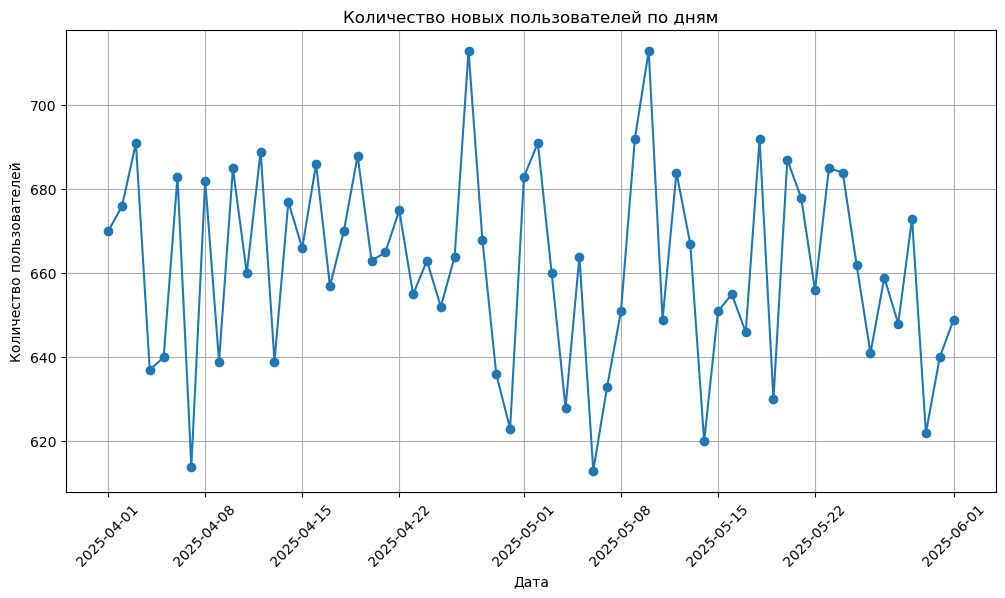

In [24]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(count_new_users['first_ts'], count_new_users['user_id'], marker='o')
plt.title('Количество новых пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [25]:
# Группировка по дням и платформам
daily_platform = new_users.groupby(['first_dt', 'platform'])['user_id'].nunique().reset_index()
daily_platform.rename(columns={'user_id': 'new_users'}, inplace=True)

In [26]:
# Группировка по дням и странам
daily_country = new_users.groupby(['first_dt', 'country_code'])['user_id'].nunique().reset_index()
daily_country.rename(columns={'user_id': 'new_users'}, inplace=True)

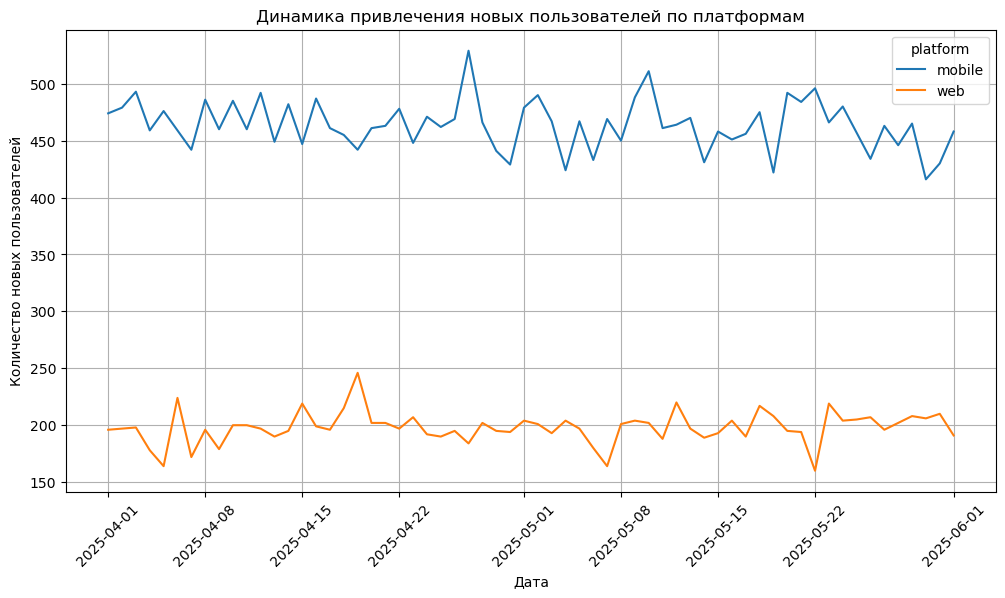

In [27]:
# График по платформам
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_platform, x='first_dt', y='new_users', hue='platform')
plt.title('Динамика привлечения новых пользователей по платформам')
plt.xlabel('Дата')
plt.ylabel('Количество новых пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

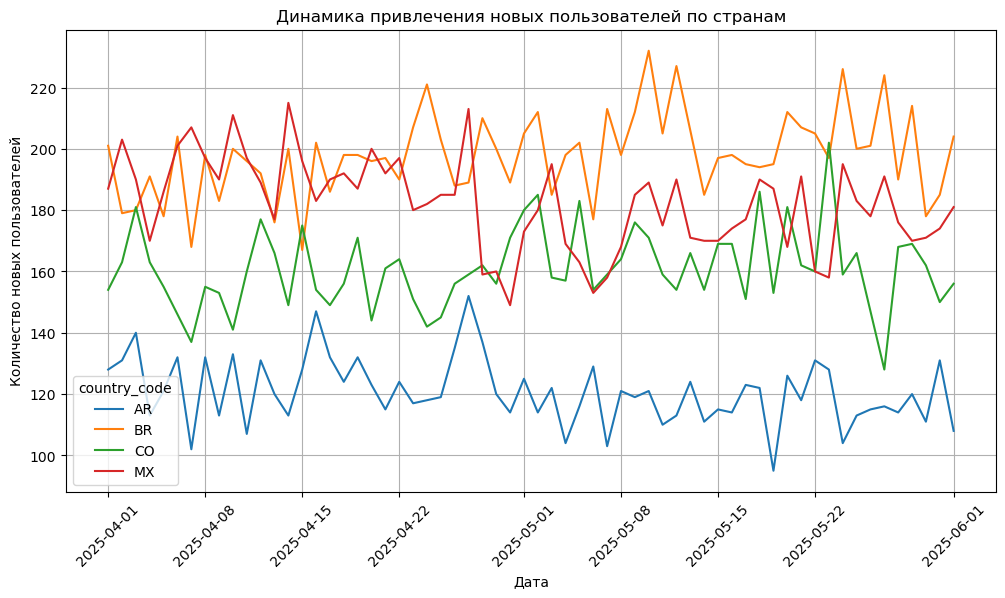

In [28]:
# График по странам
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_country, x='first_dt', y='new_users', hue='country_code')
plt.title('Динамика привлечения новых пользователей по странам')
plt.xlabel('Дата')
plt.ylabel('Количество новых пользователей')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

По графику динамики привлечения новых пользователей видны следующие особенности:
- количество новых пользователей варьируется ежедневно, наблюдаются значительные колебания.
- нет ярко выраженной тенденции роста или снижения за период — динамика скорее стабильна, но с высокой волатильностью.
- отдельные пики указывают на дни с повышенным привлечением, возможно, связанные с маркетинговыми активностями или внешними событиями.
- временами наблюдаются падения числа новых регистраций, что может быть связано с выходными, техническими проблемами или сезонными факторами.
- клиенты намного чаще заходят с мобильной версии, нежеле с Web.

**Задача 2.2.** Анализ воронок событий.
- Построим классическую и пошаговую воронки;
- Охарактеризуем пользовательский путь в приложении и определим узкие места воронки. 


In [31]:
sollmafin_hist['event_name'].unique()

array(['install / open_web', 'introduction', 'registration', 'main_page',
       'onboarding_complete', 'first_deposit', 'asset_purchase',
       'second_deposit'], dtype=object)

In [32]:
# Задаем порядок шагов в воронке
funnel_steps = ['install / open_web', 'introduction', 'registration', 'main_page', 'onboarding_complete', 'first_deposit', 'asset_purchase', 'second_deposit']

In [33]:
# Фильтруем датасет оставляя только нужные шаги воронки
funnel_df_steps = sollmafin_hist[sollmafin_hist['event_name'].isin(funnel_steps)]

In [34]:
# Считаем число уникальных пользователей на каждом шаге
funnel_counts =  funnel_df_steps.groupby('event_name')['user_id'].nunique().reindex(funnel_steps)

In [35]:
# Собираем таблицу воронки
funnel_df = pd.DataFrame({
  'step':funnel_steps,
   'users':funnel_counts.values
})

In [36]:
# Добавляем конверсии и округляем до 1 знака после запятой
funnel_df['conversion_from_first_%'] = (funnel_df['users']/funnel_df['users'][0] * 100).round(1)
funnel_df['conversion_from_previous_%'] = (funnel_df['users']/funnel_df['users'].shift() * 100).round(1)

In [37]:
print(funnel_df.head(5))

                  step  users  conversion_from_first_%  \
0   install / open_web  41032                    100.0   
1         introduction  41032                    100.0   
2         registration  38133                     92.9   
3            main_page  35040                     85.4   
4  onboarding_complete  34337                     83.7   

   conversion_from_previous_%  
0                         NaN  
1                       100.0  
2                        92.9  
3                        91.9  
4                        98.0  


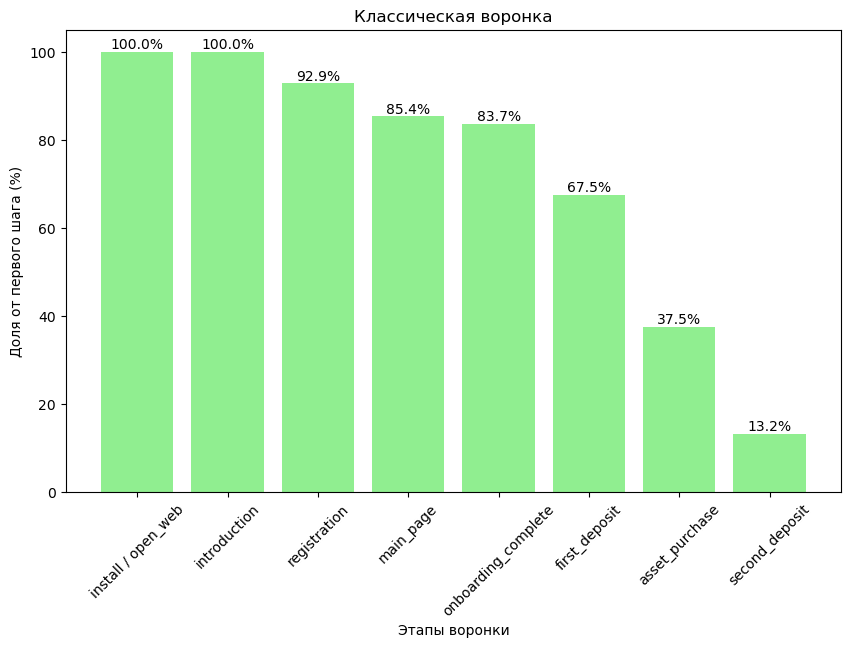

In [38]:
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df['step'], funnel_df['conversion_from_first_%'], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Классическая воронка')
plt.ylabel('Доля от первого шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

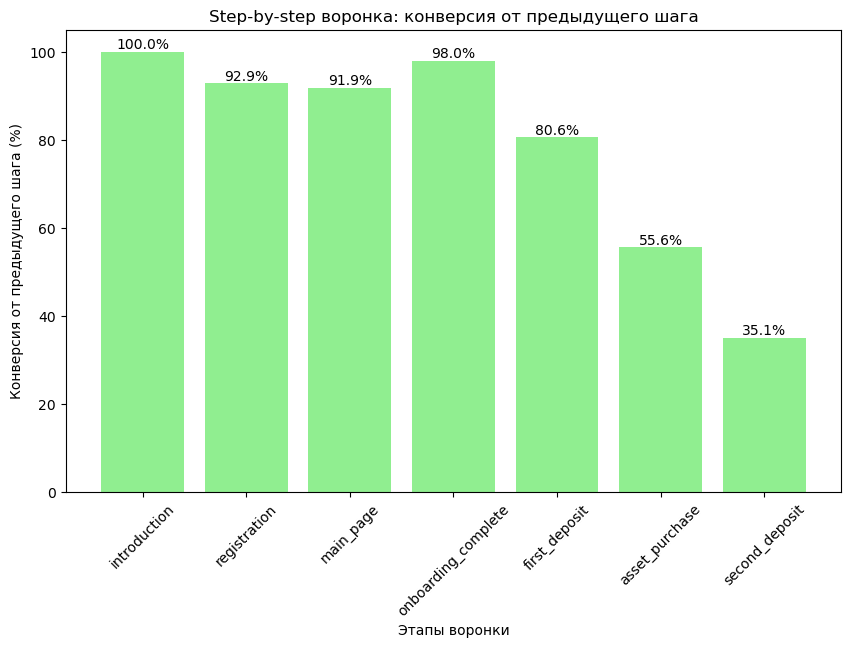

In [39]:
# Визуализируем данные, кроме первого шага, чтобы не выводить NaN
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df['step'][1:], funnel_df['conversion_from_previous_%'][1:], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Step-by-step воронка: конверсия от предыдущего шага')
plt.ylabel('Конверсия от предыдущего шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

По представленным графикам классической и пошаговой воронок событий можно сделать следующие наблюдения и выводы:

- Классическая воронка
Начальный этап (регистрация) — 100% пользователей.
Небольшие потери на следующих шагах: около 7% пользователей не доходят до выбора первого актива (92.9% остаются).
Далее постепенное снижение: 85.4%, 83.7% — пользователи продолжают взаимодействовать.
Значительный спад после этапа с 83.7% до 67.5% — здесь происходит существенный отток.
Еще более резкое падение до 37.5%, а затем до 13.2% на финальных шагах воронки.

- Пошаговая воронка
Начальный этап — 100%.
Очень небольшие потери на первых шагах (92.9%, 91.9%), затем даже небольшой рост до 98% (возможно, повторные действия или возврат пользователей).
Далее резкое падение с 98% до 80.6%, затем до 55.6%, и финальное снижение до 35.1%.

Общие выводы по воронкам

В классической воронке самый сильный отток наблюдается ближе к финалу — с 67.5% до 13.2% (на этапах пополнения первого депозита и покупки активов).

В пошаговой воронке также виден значительный отток после 80.6%, что указывает на узкое место, а именно на этапе покупки актива.
Небольшие потери на начальных этапах показывают, что регистрация и первые действия проходят относительно гладко.

**Задача 2.3.** Влияние уровня риска актива на открытие второго депозита.

In [42]:
# Фильтруем данные, оставив только события покупки активов
asset_purchase = sollmafin_hist[(sollmafin_hist['event_name'] == 'asset_purchase')]

In [43]:
asset_purchase.head()

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
12,89923614-c303-414d-9788-b5ed77ccc740,BR,mobile,2025-05-12 12:35:02,2025-05-12,2025-05-16 21:51:18,asset_purchase,NaN,stock,medium
19,df7b9aae-7475-4878-a8c7-9bd3002fa226,BR,mobile,2025-04-30 11:19:58,2025-04-30,2025-05-01 12:32:40,asset_purchase,NaN,option,high
26,f18e66dc-e9dd-4608-b067-716ec62f4e70,AR,mobile,2025-04-26 21:42:24,2025-04-26,2025-04-29 15:21:16,asset_purchase,NaN,stock,low
39,f1d9c60f-3365-4d6b-967a-099098b5efc9,MX,mobile,2025-05-15 20:26:51,2025-05-15,2025-05-17 22:07:06,asset_purchase,NaN,option,high
51,56765f29-e127-402d-b45a-96427b6c37d2,CO,mobile,2025-04-26 02:31:43,2025-04-26,2025-04-28 10:08:48,asset_purchase,NaN,crypto,high


In [44]:
# Фильтруем данные, оставив только события покупки второго актива
second_deposit = sollmafin_hist[(sollmafin_hist['event_name'] == 'second_deposit')]

In [45]:
second_deposit.head()

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
52,56765f29-e127-402d-b45a-96427b6c37d2,CO,mobile,2025-04-26 02:31:43,2025-04-26,2025-04-28 23:42:28,second_deposit,114.0,NaN,NaN
110,187ff5de-58c5-4261-8d32-ccf68ab93897,MX,mobile,2025-04-26 19:03:27,2025-04-26,2025-04-29 16:47:50,second_deposit,170.0,NaN,NaN
134,0a4cb99b-77ca-4d21-9baf-62f98b73cee0,BR,mobile,2025-05-30 11:57:19,2025-05-30,2025-06-05 06:34:50,second_deposit,136.0,NaN,NaN
148,fc369ed2-3b8b-4a1c-b5f6-c12429d88164,CO,mobile,2025-04-21 16:16:51,2025-04-21,2025-04-27 23:04:17,second_deposit,179.0,NaN,NaN
187,2d9cb7f0-5786-4742-a93a-6180ce4d3b04,CO,mobile,2025-05-15 20:10:48,2025-05-15,2025-05-19 18:21:07,second_deposit,200.0,NaN,NaN


In [46]:
# Находим количество пользователей по рискам приобретенного автива
risk_level = asset_purchase.groupby('risk_level')['user_id'].nunique().reset_index()

In [47]:
risk_level.head()

,risk_level,user_id
0,high,7740
1,low,2327
2,medium,5325


In [48]:
risk_levels = ['medium', 'high', 'low']
conversions = {}

for risk in risk_levels:
    # Фильтруем данные по уровню риска
    filtered_assets = asset_purchase[asset_purchase['risk_level'] == risk]
    
    # Объединяем для нахождения конверсии во второй депозит
    second_deposit_risk = filtered_assets.merge(second_deposit['user_id'], how='inner', on='user_id')
    
    # Рассчитываем конверсию
    conversion_rate = round((second_deposit_risk['user_id'].nunique() / filtered_assets['user_id'].nunique()) * 100, 2)
    conversions[risk] = conversion_rate
    
    print(f"Конверсия для риска {risk}: {conversion_rate}%")

Конверсия для риска medium: 42.97%
Конверсия для риска high: 26.36%
Конверсия для риска low: 46.41%


Конверсия во второй депозит с учетом приобретенного актива с высоким риском составляет 26.36%, что сильно меньше конверсии со средним уровнем риска (42.97%) и низким уровнем риска (46.41%).

**Задача 2.4.** Анализ ключевой метрики на исторических данных.
- На исторических данных рассчитаем значение ключевой метрики — средней суммы всех депозитов на одного пользователя. Учитывая всех пользователей, которые взаимодействовали с сервисом. Это позволит зафиксировать базовый уровень монетизации.

In [51]:
# Находим сумму активов на каждого пользователя
deposits = sollmafin_hist.groupby('user_id')['amount'].sum().reset_index()

In [52]:
deposits.head()

,user_id,amount
0,000194d5-0b25-4c52-834d-7c812daded6a,72.0
1,000230df-cb80-4a99-9eb4-6e7b559cbd0a,103.0
2,00031d01-a2cc-4e28-be64-84c652318cf9,316.0
3,00039a87-007c-4aea-aa7a-f0307022ae6c,123.0
4,00044258-420d-40a2-8cfe-039c6c9deffd,128.0


In [53]:
key_metric = deposits['amount'].mean().round(2)
print(f'Ключевая метрика — средняя суммы всех депозитов на одного пользователя составляет: {key_metric}')

Ключевая метрика — средняя суммы всех депозитов на одного пользователя составляет: 91.56


In [54]:
# Находим сумму активов на каждого поользователя в разрезе страны
deposits_country = sollmafin_hist.groupby(['country_code', 'user_id'])['amount'].sum().reset_index()

In [55]:
key_metric_country = deposits_country.groupby('country_code')['amount'].mean()

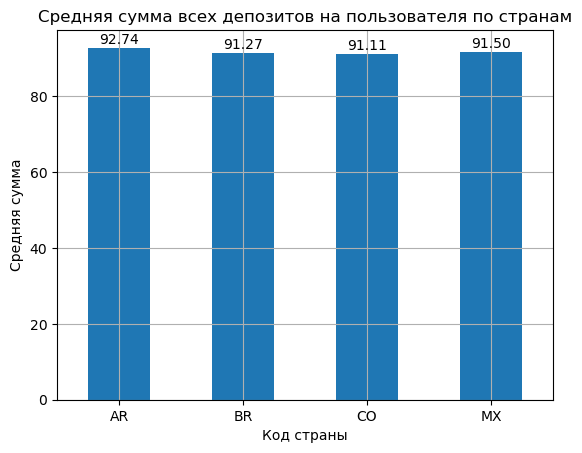

In [56]:
# Построение графика
ax = key_metric_country.plot(
               kind='bar', 
               rot=0, 
               legend=False,
               title=f'Средняя сумма всех депозитов на пользователя по странам'
)
ax.bar_label(ax.containers[0], fmt = '%.2f', padding = 1)
# Настраиваем оформление графика
plt.xlabel('Код страны')
plt.ylabel('Средняя сумма')
# Добавляем сетку графика
plt.grid()
# Выводим график
plt.show()

Средняя сумма депозитов на одного пользователя стабильна, что указывает на устойчивый базовый уровень монетизации приложения. Отсутствие значительных колебаний говорит о том, что пользователи в среднем вносят примерно одинаковые суммы, и нет заметных трендов роста или падения этой метрики.

In [58]:
# Среднее и std по всем пользователям
mean_deposit = deposits['amount'].mean()
std_deposit = deposits['amount'].std()

print(f"Средняя сумма депозитов на пользователя: {mean_deposit:.2f}")
print(f"Стандартное отклонение: {std_deposit:.2f}")

Средняя сумма депозитов на пользователя: 91.56
Стандартное отклонение: 80.39


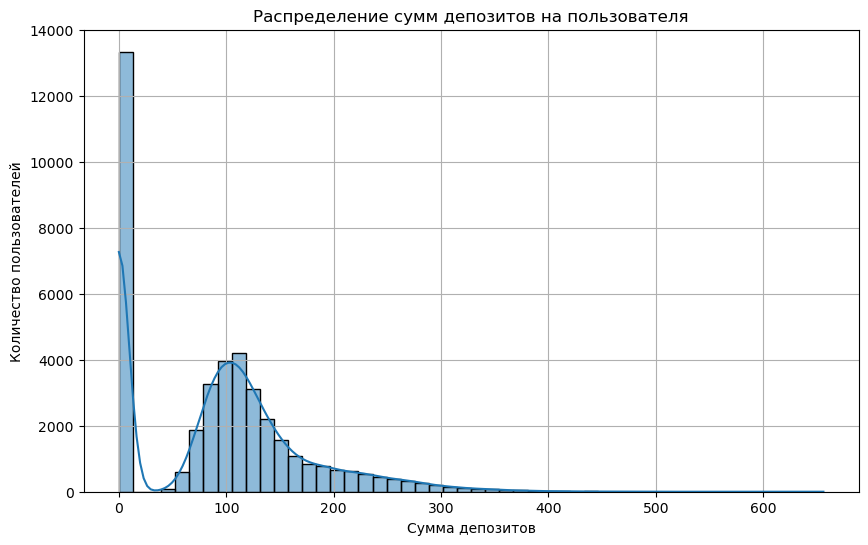

In [59]:
# Гистограмма распределения сумм депозитов
plt.figure(figsize=(10, 6))
sns.histplot(deposits['amount'], bins=50, kde=True)
plt.title('Распределение сумм депозитов на пользователя')
plt.xlabel('Сумма депозитов')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

По представленному графику можно сделать следующие выводы:

Распределение данных явно несимметрично и имеет сильный сдвиг вправо (положительная асимметрия).
Наблюдается два выраженных пика: первый пик, расположенный около нуля, указываеат на большое количество значений, близких к нулю.
Второй пик расположен примерно в диапазоне 80-100 и имеет более широкое распределение, что говорит о наличии второй группы данных с более разбросанными значениями.
После второго пика наблюдается постепенное снижение частоты значений, распределение "хвостом" тянется вправо, что свидетельствует о наличии редких, но достаточно больших значений.
Такое распределение может указывать на наличие выбросов и экстремальных значений.

---

## Часть 2

### 3. Исследование результатов А/В эксперимента

In [62]:
# Выгружаем данные 
sollmafin_abt = pd.read_csv('https://code.s3.yandex.net/datasets/pa_sollmafin_abt.csv')

In [63]:
# Фильтруем данные по дате
sollmafin_abt = sollmafin_abt[(sollmafin_abt['first_dt'] >= '2025-06-02') & (sollmafin_abt['first_dt'] <= '2025-06-15')]

In [64]:
sollmafin_abt.head()

,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,ab_test,group,amount,asset,risk_level
0,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:51,install / open_web,onboarding_test,test,NaN,NaN,NaN
1,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:54,introduction,onboarding_test,test,NaN,NaN,NaN
2,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:09,registration,onboarding_test,test,NaN,NaN,NaN
3,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:13,main_page,onboarding_test,test,NaN,NaN,NaN
4,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:33:40,onboarding_complete,onboarding_test,test,NaN,NaN,NaN


In [65]:
sollmafin_abt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54805 entries, 0 to 54804
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       54805 non-null  object 
 1   country_code  54805 non-null  object 
 2   platform      54805 non-null  object 
 3   first_ts      54805 non-null  object 
 4   first_dt      54805 non-null  object 
 5   event_ts      54805 non-null  object 
 6   event_name    54805 non-null  object 
 7   ab_test       54805 non-null  object 
 8   group         54805 non-null  object 
 9   amount        7843 non-null   float64
 10  asset         3750 non-null   object 
 11  risk_level    3750 non-null   object 
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [66]:
# Преобразуем даты в формат datetime
sollmafin_abt['first_ts'] = pd.to_datetime(sollmafin_abt['first_ts'])
sollmafin_abt['first_dt'] = pd.to_datetime(sollmafin_abt['first_dt'])
sollmafin_abt['event_ts'] = pd.to_datetime(sollmafin_abt['event_ts'])

In [67]:
# Поиск явных дубликатов
print(sollmafin_abt.duplicated().sum())

0


In [68]:
# Проверим данные на дубликаты по id пользователя, дате и названия события
sollmafin_abt[['user_id','event_ts','event_name']].duplicated().sum()

0

In [69]:
sollmafin_abt['event_name'].unique()

array(['install / open_web', 'introduction', 'registration', 'main_page',
       'onboarding_complete', 'first_deposit', 'asset_purchase',
       'second_deposit'], dtype=object)

In [70]:
sollmafin_abt['group'].unique()

array(['test', 'control'], dtype=object)

In [71]:
sollmafin_abt['risk_level'].unique()

array([nan, 'high', 'low', 'medium'], dtype=object)

In [72]:
sollmafin_abt['platform'].unique()

array(['mobile', 'web'], dtype=object)

In [73]:
sollmafin_abt['country_code'].unique()

array(['BR', 'MX', 'CO', 'AR'], dtype=object)

Преобразовали столбцы с датами в формат datetime, явных дубликатов не найдено. Пропуски оставили, так как не все пользователи открывали депозиты.

**Задача 3.1.** Анализ аудитории эксперимента. 
- Проверим корректность распределения новых пользователей по группам А/В-эксперимента. 

In [76]:
# Размеры групп
group_sizes = sollmafin_abt.groupby('group')['user_id'].nunique()
print("Количество уникальных пользователей по группам:")
print(group_sizes)

Количество уникальных пользователей по группам:
group
control    4847
test       4568
Name: user_id, dtype: int64


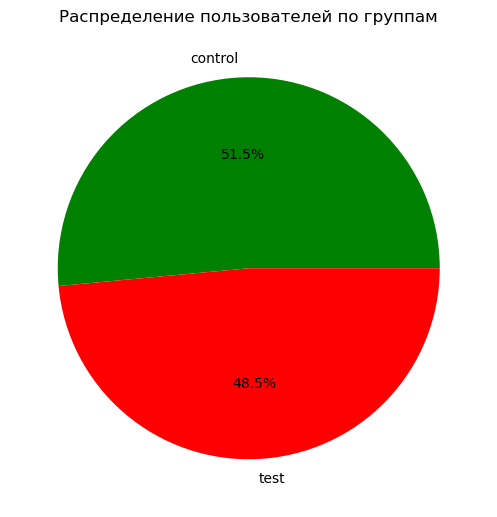

In [77]:
# Визуализация распределения пользователей по группам
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pie(group_sizes.values, labels=group_sizes.index, autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Распределение пользователей по группам')
plt.tight_layout()
plt.show()

In [78]:
# Проверим нет ли пользователей, попавших в обе группы
test_group = sollmafin_abt[sollmafin_abt['group'] == 'test']
control_group = sollmafin_abt[sollmafin_abt['group'] == 'control']
intersection = list(set(test_group['user_id']) & set(control_group['user_id']))
print(intersection) 

[]


По представленному круговому графику видно, что распределение новых пользователей по группам А и В в А/В-эксперименте примерно равное: группа А составляет 48.5%, а группа В — 51.5%, что свидетельствует о корректной случайной выборке и отсутствии значительного перекоса в распределении. Также отсутствуют пользователи попавшие в обе группы.

**Задача 3.2.** Сравнение воронок событий.
- Сравним пользовательский путь новых пользователей в тестовой и контрольной группах.
- Построим классическую и последовательную воронки.

In [81]:
# Задаем порядок шагов в воронке
funnel_steps_test = ['install / open_web', 'introduction', 'registration', 'main_page', 'onboarding_complete', 'first_deposit', 'asset_purchase', 'second_deposit']

In [82]:
# Фильтруем датасет оставляя только нужные шаги воронки
funnel_df_steps_test = test_group[test_group['event_name'].isin(funnel_steps_test)]

In [83]:
# Считаем число уникальных пользователей на каждом шаге
funnel_counts_test =  funnel_df_steps_test.groupby('event_name')['user_id'].nunique().reindex(funnel_steps_test)

In [84]:
# Собираем таблицу воронки
funnel_df_test = pd.DataFrame({
  'step':funnel_steps_test,
   'users':funnel_counts_test.values
})

In [85]:
# Добавляем конверсии и округляем до 1 знака после запятой
funnel_df_test['conversion_from_first_%'] = (funnel_df_test['users']/funnel_df_test['users'][0] * 100).round(1)
funnel_df_test['conversion_from_previous_%'] = (funnel_df_test['users']/funnel_df_test['users'].shift() * 100).round(1)

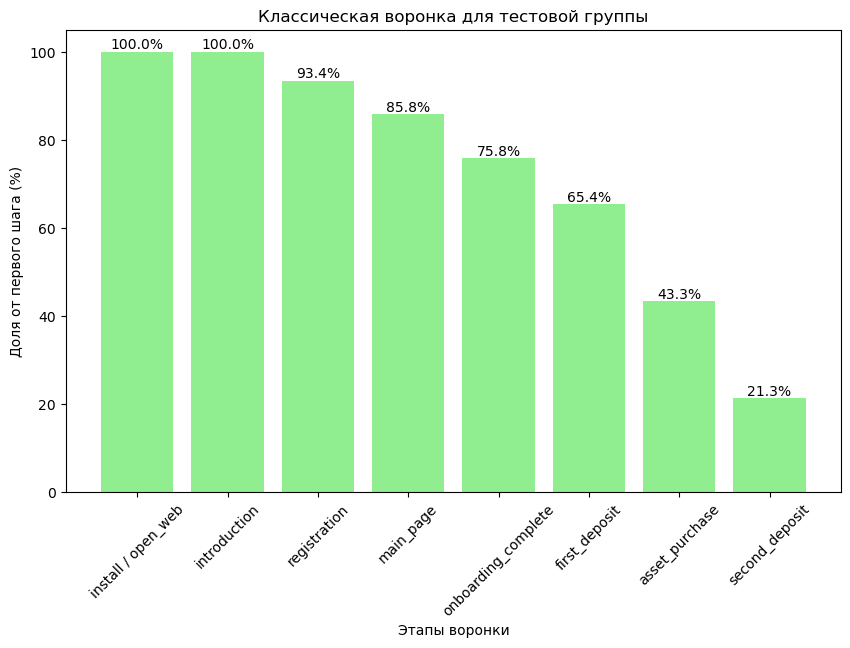

In [86]:
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df_test['step'], funnel_df_test['conversion_from_first_%'], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Классическая воронка для тестовой группы')
plt.ylabel('Доля от первого шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

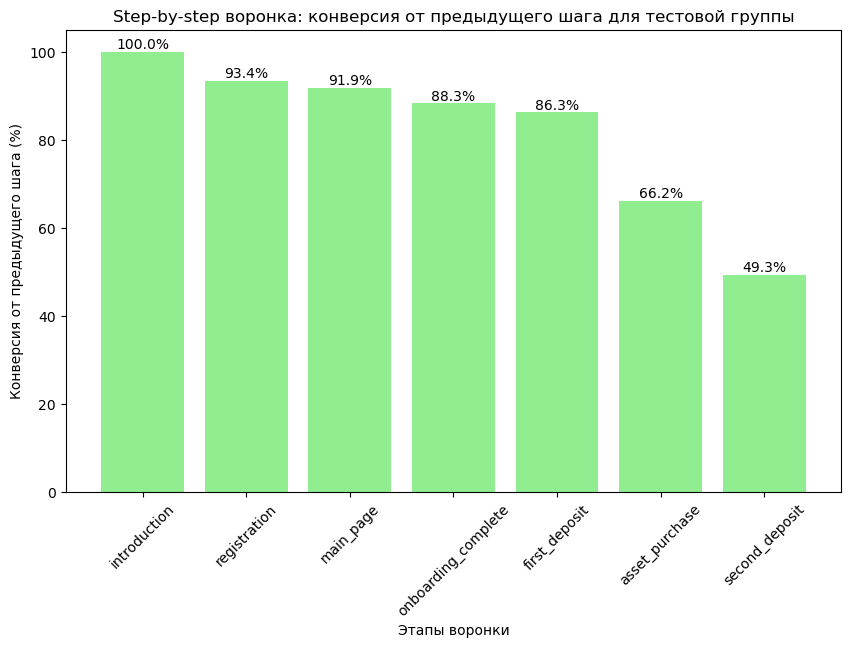

In [87]:
# Визуализируем данные, кроме первого шага, чтобы не выводить NaN
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df_test['step'][1:], funnel_df_test['conversion_from_previous_%'][1:], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Step-by-step воронка: конверсия от предыдущего шага для тестовой группы')
plt.ylabel('Конверсия от предыдущего шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

По представленным графикам можно сделать следующие выводы о пользовательском пути новых пользователей в тестовой группе:

На первом графике виден классический пользовательский путь с постепенным снижением конверсии на каждом этапе:

Начало 100%, затем плавное снижение до 65.4% на среднем этапе.
Значительный отток на последних шагах: падение с 65.4% до 43.3%, и особенно до 21.3%.
Это указывает на существенные потери пользователей на этапе покупки активов и открытия депозитов.

На втором графике конверсия сохраняется на более высоком уровне на первых этапах:

Снижение с 100% до 86.3% происходит более плавно.
Однако далее также наблюдается значительный спад — до 66.2% и 49.3% на последних этапах.

In [89]:
# Задаем порядок шагов в воронке
funnel_steps_control = ['install / open_web', 'introduction', 'registration', 'main_page', 'onboarding_complete', 'first_deposit', 'asset_purchase', 'second_deposit']

In [90]:
# Фильтруем датасет оставляя только нужные шаги воронки
funnel_df_steps_control = control_group[control_group['event_name'].isin(funnel_steps_control)]

In [91]:
# Считаем число уникальных пользователей на каждом шаге
funnel_counts_control =  funnel_df_steps_control.groupby('event_name')['user_id'].nunique().reindex(funnel_steps_control)

In [92]:
# Собираем таблицу воронки
funnel_df_control = pd.DataFrame({
  'step':funnel_steps_control,
   'users':funnel_counts_control.values
})

In [93]:
# Добавляем конверсии и округляем до 1 знака после запятой
funnel_df_control['conversion_from_first_%'] = (funnel_df_control['users']/funnel_df_control['users'][0] * 100).round(1)
funnel_df_control['conversion_from_previous_%'] = (funnel_df_control['users']/funnel_df_control['users'].shift() * 100).round(1)

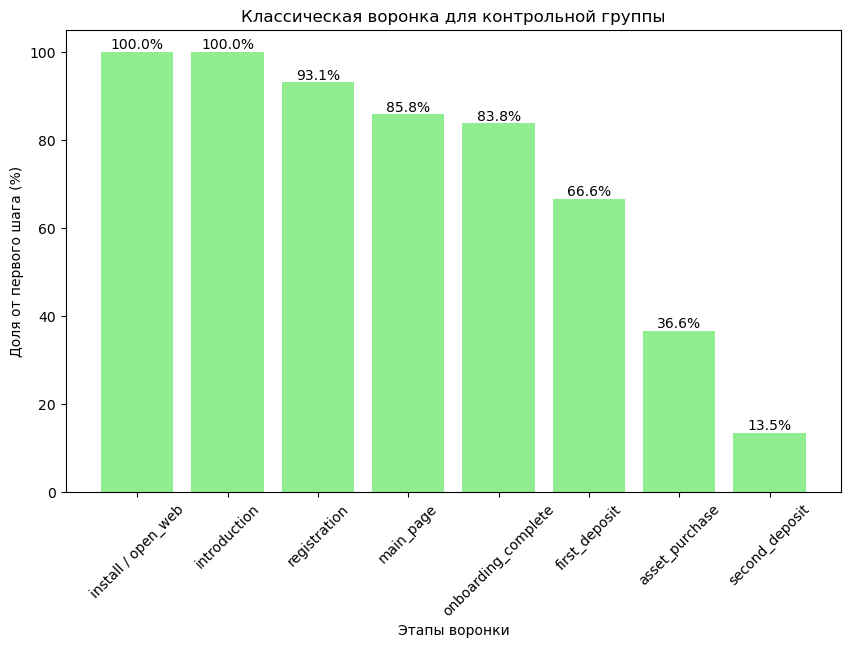

In [94]:
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df_control['step'], funnel_df_control['conversion_from_first_%'], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Классическая воронка для контрольной группы')
plt.ylabel('Доля от первого шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

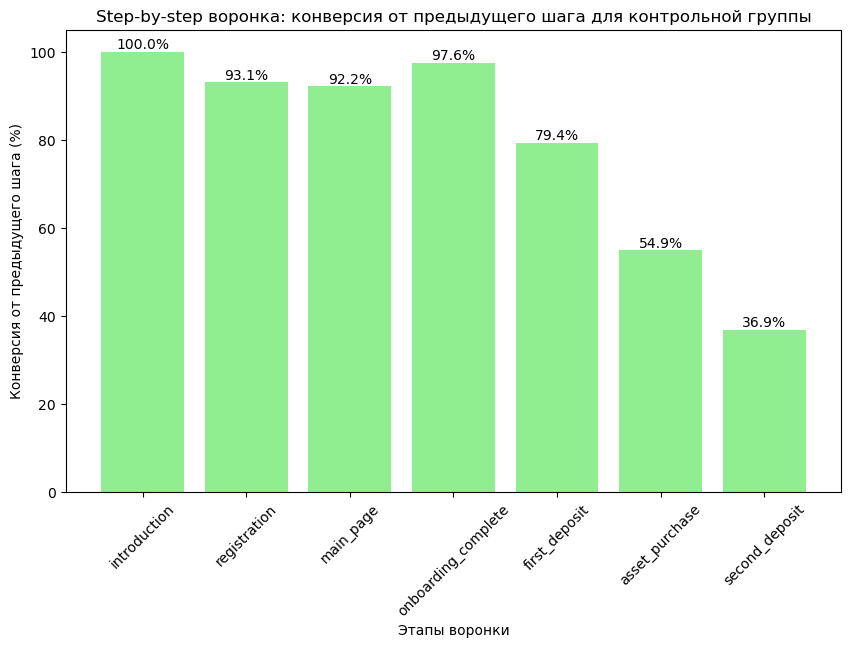

In [95]:
# Визуализируем данные, кроме первого шага, чтобы не выводить NaN
plt.figure(figsize=(10, 6))
bars = plt.bar(funnel_df_control['step'][1:], funnel_df_control['conversion_from_previous_%'][1:], color='lightgreen')
# Добавляем значения конверсии на столбцы
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
plt.title('Step-by-step воронка: конверсия от предыдущего шага для контрольной группы')
plt.ylabel('Конверсия от предыдущего шага (%)')
plt.xlabel('Этапы воронки')
plt.xticks(rotation=45)
plt.show()

По представленным графикам пользовательского пути контрольной группы можно сделать следующие выводы:

На первом графике контрольной группы наблюдается постепенное снижение конверсии на каждом этапе:

Снижение с 100% до 83.8% происходит плавно.
Далее резкий спад до 66.6%, затем значительный отток на последних шагах — до 36.6% и 13.5% на финальном этапе.
Отток в конце пути более выражен, чем в тестовой группе.

На втором графике контрольной группы видна более плавная конверсия на первых этапах:

Стабильность на уровне 90% до этапа покупки депозита.
Затем падение до 79.4%, и более резкое снижение на последних этапах, т.е. на этапах покупки активов и депозита — до 54.9% и 36.9%.
Отток на последних этапах меньше, чем на первом графике, но все равно значителен.

**Задача 3.3.** Влияние новой фичи на конверсию во второй депозит с учётом уровня риска купленного актива.
- Проанализируем, как категория риска купленного актива влияет на вероятность открытия второго депозита в тестовой и контрольной группах. 
- Сравним результаты и оценим, есть ли статистически значимая разница между группами. 

In [98]:
# Фильтрация событий
first_deposit = sollmafin_abt[sollmafin_abt['event_name'] == 'first_deposit']
second_deposit = sollmafin_abt[sollmafin_abt['event_name'] == 'second_deposit']
asset_purchase = sollmafin_abt[sollmafin_abt['event_name'] == 'asset_purchase']

In [99]:
first_deposit = first_deposit[['user_id', 'group']]
second_deposit = second_deposit[['user_id']]
asset_purchase = asset_purchase[['user_id', 'risk_level']]

In [100]:
# Объединяем данные
merged_data = first_deposit.merge(asset_purchase, on='user_id', how='inner')

In [101]:
# Определяем, открыл ли пользователь второй депозит
merged_data['opened_second_deposit'] = merged_data['user_id'].isin(second_deposit['user_id'])

In [102]:
# Сводная таблица с конверсией
conversion_rates = merged_data.groupby(['group', 'risk_level'], as_index=False).agg(
    total_users=('user_id', 'count'),
    converted_users=('opened_second_deposit', 'sum')
)
conversion_rates['conversion_rate'] = conversion_rates['converted_users'] / conversion_rates['total_users']
print("\nТаблица конверсии во второй депозит:")
print(conversion_rates)


Таблица конверсии во второй депозит:
     group risk_level  total_users  converted_users  conversion_rate
0  control       high          893              247         0.276596
1  control        low          285              142         0.498246
2  control     medium          595              265         0.445378
3     test       high          737              339         0.459973
4     test        low          496              285         0.574597
5     test     medium          744              350         0.470430


H0: Новый онбординг не влияет на конверсию во второй депозит

H1: Новый онбординг влияет на конверсию во второй депозит

In [104]:
# статистический анализ 
print("Z-тест для сравнения конверсий между группами")

results_ztest = []

for risk in merged_data['risk_level'].unique():
    control_group_risk = merged_data[(merged_data['group'] == 'control') & (merged_data['risk_level'] == risk)]
    test_group_risk = merged_data[(merged_data['group'] == 'test') & (merged_data['risk_level'] == risk)]
    
    # Подготовка данных для Z-теста
    successes = [control_group_risk['opened_second_deposit'].sum(), 
                 test_group_risk['opened_second_deposit'].sum()]
    nobs = [len(control_group_risk), len(test_group_risk)]
    
    # Z-тест для двух пропорций
    z_stat, p_value = proportions_ztest(successes, nobs)
    
    # Расчет доверительного интервала для разницы долей
    p1 = successes[0] / nobs[0]
    p2 = successes[1] / nobs[1]
    se = np.sqrt(p1*(1-p1)/nobs[0] + p2*(1-p2)/nobs[1])
    margin = 1.96 * se
    ci_lower = (p2 - p1) - margin
    ci_upper = (p2 - p1) + margin
    
    results_ztest.append({
        'risk_level': risk,
        'control_conversion': p1,
        'test_conversion': p2,
        'absolute_difference': p2 - p1,
        'relative_difference': (p2 / p1 - 1) if p1 > 0 else np.nan,
        'z_statistic': z_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })
    
    print(f"\nУровень риска: {risk}")
    print(f"Конверсия Control: {p1:.4f} ({successes[0]}/{nobs[0]})")
    print(f"Конверсия Test:    {p2:.4f} ({successes[1]}/{nobs[1]})")
    print(f"Разница: {p2-p1:.4f} ({((p2/p1-1)*100):.1f}%)")
    print(f"95% ДИ разницы: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        if p2 > p1:
            print(f"Новый онбординг улучшил конверсию")
        else:
            print(f"Новый онбординг ухудшил конверсию")
    else:
        print(f"Статистически значимого различия нет")

results_ztest_df = pd.DataFrame(results_ztest)

Z-тест для сравнения конверсий между группами

Уровень риска: high
Конверсия Control: 0.2766 (247/893)
Конверсия Test:    0.4600 (339/737)
Разница: 0.1834 (66.3%)
95% ДИ разницы: [0.1369, 0.2298]
p-value: 0.0000
Новый онбординг улучшил конверсию

Уровень риска: low
Конверсия Control: 0.4982 (142/285)
Конверсия Test:    0.5746 (285/496)
Разница: 0.0764 (15.3%)
95% ДИ разницы: [0.0038, 0.1489]
p-value: 0.0391
Новый онбординг улучшил конверсию

Уровень риска: medium
Конверсия Control: 0.4454 (265/595)
Конверсия Test:    0.4704 (350/744)
Разница: 0.0251 (5.6%)
95% ДИ разницы: [-0.0286, 0.0787]
p-value: 0.3607
Статистически значимого различия нет


Новый онбординг существенно улучшает конверсию во второй депозит для пользователей, купивших активы с высоким и низким уровнем риска. Для средней категории риска улучшение не является статистически значимым. Это говорит о том, что новая фича наиболее эффективна для пользователей с крайними уровнями риска, и стоит уделить внимание именно этим сегментам при дальнейшем развитии продукта.

**Задача 3.4.** Анализ метрик А/В-эксперимента. 
- Ключевая метрика — средняя сумма всех депозитов на одного пользователя (включая тех, кто установил приложение или открыл веб-версию).
- Барьерная метрика — конверсия из регистрации в первый депозит.
- Вспомогательная метрика 1 — конверсия из первого депозита во второй.
- Вспомогательная метрика 2 — средняя сумма всех депозитов на пользователя, который открыл хотя бы один депозит.

Для каждой метрики выведем: 
- значения в контрольной и тестовой группах, 
- абсолютные и относительные изменения значений в тестовой группе по сравнению с контрольной.

In [107]:
# Группируем данных по user_id и group
grouped = sollmafin_abt.groupby(['user_id', 'group']).agg({
    'event_name': list,
    'amount': list,
    'first_dt': 'first'
}).reset_index()

In [108]:
# Функция для расчета метрик на пользователя
def calculate_metrics(grouped_df):
    metrics = []
    for _, row in grouped_df.iterrows():
        user_id = row['user_id']
        group = row['group']
        events = row['event_name']
        amounts = row['amount']
        first_dt = row['first_dt']
        
        # Сумма депозитов
        total_deposit = 0
        has_first_deposit = 'first_deposit' in events
        has_second_deposit = 'second_deposit' in events
        if has_first_deposit:
            total_deposit += amounts[events.index('first_deposit')]
        if has_second_deposit:
            total_deposit += amounts[events.index('second_deposit')]
        
        metrics.append({
            'user_id': user_id,
            'group': group,
            'total_deposit': total_deposit,
            'has_first_deposit': has_first_deposit,
            'has_second_deposit': has_second_deposit,
            'first_dt': first_dt
        })
    
    return pd.DataFrame(metrics)

user_metrics = calculate_metrics(grouped)

In [109]:
user_metrics.head()

,user_id,group,total_deposit,has_first_deposit,has_second_deposit,first_dt
0,0004bdca-bbb8-4135-ac72-7b6f5684fa69,control,0.0,False,False,2025-06-03
1,0009aedc-c389-4824-a05a-2354883b8c7e,test,174.0,True,True,2025-06-03
2,00182318-c562-43df-98d3-ca0d7bfd2565,test,74.0,True,False,2025-06-07
3,00191c86-8925-483c-9e4c-0859df770f3a,test,64.0,True,False,2025-06-05
4,001a5423-cc86-457d-929b-b8331fff37c5,control,0.0,False,False,2025-06-06


In [110]:
# Группировка по группам
control = user_metrics[user_metrics['group'] == 'control']
test = user_metrics[user_metrics['group'] == 'test']

**Ключевая метрика — средняя сумма всех депозитов на пользователя:**

H0: Средняя сумма депозитов в тестовой группе не отличается от контрольной.

H1: Средняя сумма депозитов в тестовой группе отличается от контрольной.

In [112]:
# Метрика 1: Средняя сумма всех депозитов на пользователя (включая 0)
avg_deposit_control = control['total_deposit'].mean()
avg_deposit_test = test['total_deposit'].mean()
abs_change = avg_deposit_test - avg_deposit_control
rel_change = (abs_change / avg_deposit_control) * 100 if avg_deposit_control != 0 else 0

print("Ключевая метрика: Средняя сумма депозитов на пользователя")
print(f"Контрольная группа: {avg_deposit_control:.2f}")
print(f"Тестовая группа: {avg_deposit_test:.2f}")
print(f"Абсолютное изменение: {abs_change:.2f}")
print(f"Относительное изменение: {rel_change:.2f}%")

Ключевая метрика: Средняя сумма депозитов на пользователя
Контрольная группа: 90.24
Тестовая группа: 92.46
Абсолютное изменение: 2.22
Относительное изменение: 2.46%


**Барьерная метрика — конверсия из регистрации в первый депозит:**

H0: Конверсия в первый депозит в тестовой группе равна конверсии в контрольной.

H1: Конверсии различаются.

In [114]:
# Метрика 2: Конверсия из регистрации в первый депозит
conv_first_control = control['has_first_deposit'].mean() * 100
conv_first_test = test['has_first_deposit'].mean() * 100
abs_change_conv = conv_first_test - conv_first_control
rel_change_conv = (abs_change_conv / conv_first_control) * 100 if conv_first_control != 0 else 0

print("\nБарьерная метрика: Конверсия в первый депозит")
print(f"Контрольная группа: {conv_first_control:.2f}%")
print(f"Тестовая группа: {conv_first_test:.2f}%")
print(f"Абсолютное изменение: {abs_change_conv:.2f}%")
print(f"Относительное изменение: {rel_change_conv:.2f}%")


Барьерная метрика: Конверсия в первый депозит
Контрольная группа: 66.60%
Тестовая группа: 65.39%
Абсолютное изменение: -1.21%
Относительное изменение: -1.81%


**Вспомогательная метрика 1 — конверсия из первого депозита во второй:**

H0: Конверсия из первого во второй депозит в тестовой группе равна контрольной.
    
H1: Конверсии различаются.

In [116]:
# Метрика 3: Конверсия из первого депозита во второй (только среди тех, кто сделал первый)
control_with_first = control[control['has_first_deposit']]
test_with_first = test[test['has_first_deposit']]
conv_second_control = control_with_first['has_second_deposit'].mean() * 100 if len(control_with_first) > 0 else 0
conv_second_test = test_with_first['has_second_deposit'].mean() * 100 if len(test_with_first) > 0 else 0
abs_change_conv2 = conv_second_test - conv_second_control
rel_change_conv2 = (abs_change_conv2 / conv_second_control) * 100 if conv_second_control != 0 else 0

print("\nВспомогательная метрика 1: Конверсия в второй депозит")
print(f"Контрольная группа: {conv_second_control:.2f}%")
print(f"Тестовая группа: {conv_second_test:.2f}%")
print(f"Абсолютное изменение: {abs_change_conv2:.2f}%")
print(f"Относительное изменение: {rel_change_conv2:.2f}%")


Вспомогательная метрика 1: Конверсия в второй депозит
Контрольная группа: 20.26%
Тестовая группа: 32.61%
Абсолютное изменение: 12.35%
Относительное изменение: 60.95%


**Вспомогательная метрика 2 — средняя сумма всех депозитов на пользователя с хотя бы одним депозитом:**

H0: Средняя сумма депозитов среди платящих пользователей в тестовой группе равна контрольной.
    
H1: Средние суммы различаются.

In [118]:
# Метрика 4: Средняя сумма депозитов на пользователя с хотя бы одним депозитом
control_depositors = control[control['total_deposit'] > 0]
test_depositors = test[test['total_deposit'] > 0]
avg_deposit_depositors_control = control_depositors['total_deposit'].mean() if len(control_depositors) > 0 else 0
avg_deposit_depositors_test = test_depositors['total_deposit'].mean() if len(test_depositors) > 0 else 0
abs_change_dep = avg_deposit_depositors_test - avg_deposit_depositors_control
rel_change_dep = (abs_change_dep / avg_deposit_depositors_control) * 100 if avg_deposit_depositors_control != 0 else 0

print("\nВспомогательная метрика 2: Средняя сумма депозитов на пользователя с депозитом")
print(f"Контрольная группа: {avg_deposit_depositors_control:.2f}")
print(f"Тестовая группа: {avg_deposit_depositors_test:.2f}")
print(f"Абсолютное изменение: {abs_change_dep:.2f}")
print(f"Относительное изменение: {rel_change_dep:.2f}%")


Вспомогательная метрика 2: Средняя сумма депозитов на пользователя с депозитом
Контрольная группа: 135.50
Тестовая группа: 141.40
Абсолютное изменение: 5.90
Относительное изменение: 4.35%


In [119]:
# Для средних: t-test
t_stat_deposit, p_deposit = stats.ttest_ind(control['total_deposit'], test['total_deposit'])
t_stat_dep_depositors, p_dep_depositors = stats.ttest_ind(
    control_depositors['total_deposit'], 
    test_depositors['total_deposit']
)

In [120]:
# z-test 
from statsmodels.stats.proportion import proportions_ztest
count_control_first = control['has_first_deposit'].sum()
nobs_control_first = len(control)
count_test_first = test['has_first_deposit'].sum()
nobs_test_first = len(test)
z_stat_first, p_first = proportions_ztest([count_control_first, count_test_first], [nobs_control_first, nobs_test_first])

count_control_second = control_with_first['has_second_deposit'].sum()
nobs_control_second = len(control_with_first)
count_test_second = test_with_first['has_second_deposit'].sum()
nobs_test_second = len(test_with_first)
if nobs_control_second > 0 and nobs_test_second > 0:
    z_stat_second, p_second = proportions_ztest([count_control_second, count_test_second], [nobs_control_second, nobs_test_second])
else:
    p_second = 1  # Не значимо, если нет данных

print("\nСтатистическая значимость:")
print(f"Ключевая метрика (t-test): p-value = {p_deposit:.4f}")
print(f"Барьерная метрика (z-test): p-value = {p_first:.4f}")
print(f"Вспомогательная 1 (z-test): p-value = {p_second:.4f}")
print(f"Вспомогательная 2 (t-test): p-value = {p_dep_depositors:.4f}")


Статистическая значимость:
Ключевая метрика (t-test): p-value = 0.3313
Барьерная метрика (z-test): p-value = 0.2161
Вспомогательная 1 (z-test): p-value = 0.0000
Вспомогательная 2 (t-test): p-value = 0.0347


In [121]:
sollmafin_abt['event_day'] = sollmafin_abt['event_ts'].dt.date

In [122]:
sollmafin_abt['event_day'] = pd.to_datetime(sollmafin_abt['event_day'])

In [123]:
sollmafin_abt = sollmafin_abt[(sollmafin_abt['event_day'] >= '2025-06-02') & (sollmafin_abt['event_day'] <= '2025-06-15')]

In [124]:
records = []

for current_date in sorted(sollmafin_abt['event_day'].unique()):

  deposits_to_date  = sollmafin_abt[sollmafin_abt['event_day'] <= current_date]
  user_amount = deposits_to_date .groupby(['group', 'user_id'])['amount'].sum().reset_index()
  mean_amount = user_amount.groupby('group')['amount'].mean().reset_index()
  mean_amount['date'] = current_date

  records.append(mean_amount)

mean_amount_df = pd.concat(records)

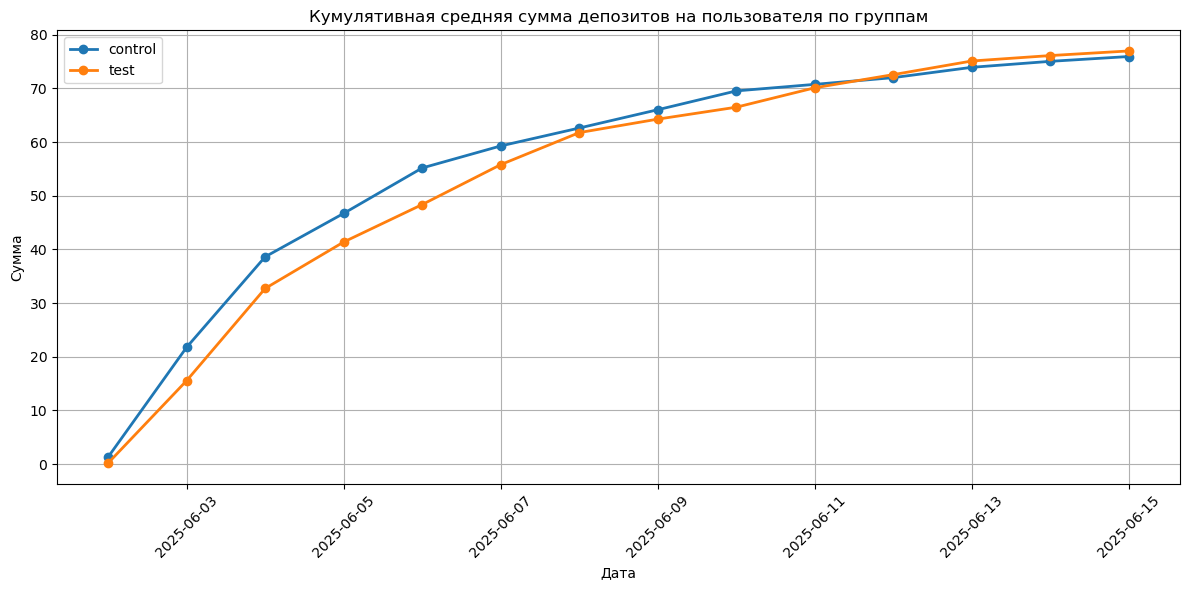

In [125]:
plt.figure(figsize=(12, 6))

for group in mean_amount_df['group'].unique():
    plot_data = mean_amount_df[mean_amount_df['group'] == group]
    plt.plot(plot_data.date, plot_data.amount, label=group, marker='o', linewidth=2)

plt.title('Кумулятивная средняя сумма депозитов на пользователя по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

По представленному графику можно сделать следующие выводы:

В начале периода контрольная группа показывает более высокие значения по сравнению с тестовой группой, однако тестовая группа быстро догоняет и затем обгоняет контрольную.

В середине периода наблюдаются колебания в обеих группах, при этом показатели тестовой группы более изменчивы, но в целом находятся на уровне, сравнимом с контрольной.

В конце периода тестовая группа демонстрирует рост и превосходит контрольную группу по показателю.

Контрольная группа показывает более стабильную, но менее выраженную положительную динамику.

Общий вывод:
Тестовая группа после начального отставания демонстрирует устойчивый рост и превосходит контрольную группу в конце периода, что свидетельствует о положительном эффекте внедрённой новой фичи или изменения. Это подтверждает эффективность изменений, применённых в тестовой группе.

In [127]:
# Выделение дня активности
sollmafin_abt['day_active'] = sollmafin_abt['event_ts'].dt.date

In [128]:
# Группировка суммы amount по дню, пользователю и группе
arpu_by_day = sollmafin_abt.groupby(['day_active', 'user_id', 'group']).agg({'amount': 'sum'}).reset_index()

In [129]:
# Пустой список для результатов
pval_records = []
# Расчёт p-value по дням
for current_date in sorted(arpu_by_day['day_active'].unique()):
    # Все события до текущей даты
    active_to_date = arpu_by_day[arpu_by_day['day_active'] <= current_date]
    # Сколько уникальных дней активности у каждого пользователя
    arpu = active_to_date.groupby(['user_id', 'group'])['amount'].sum().reset_index()
    # Объявление переменных с данными по каждой группе
    control_1 = arpu[arpu['group'] == 'control']['amount']
    test_1 = arpu[arpu['group'] == 'test']['amount']
    # Проверка наличия данных в обеих группах
    if len(control_1) > 0 and len(test_1) > 0:
        # Расчёт p-value
        p_val_ab = ttest_ind(control_1, test_1, equal_var=False).pvalue
        
    pval_records.append({'date': current_date,'p_value_ab': p_val_ab})

# Преобразование результатов в DataFrame
pval_records_df = pd.DataFrame(pval_records)

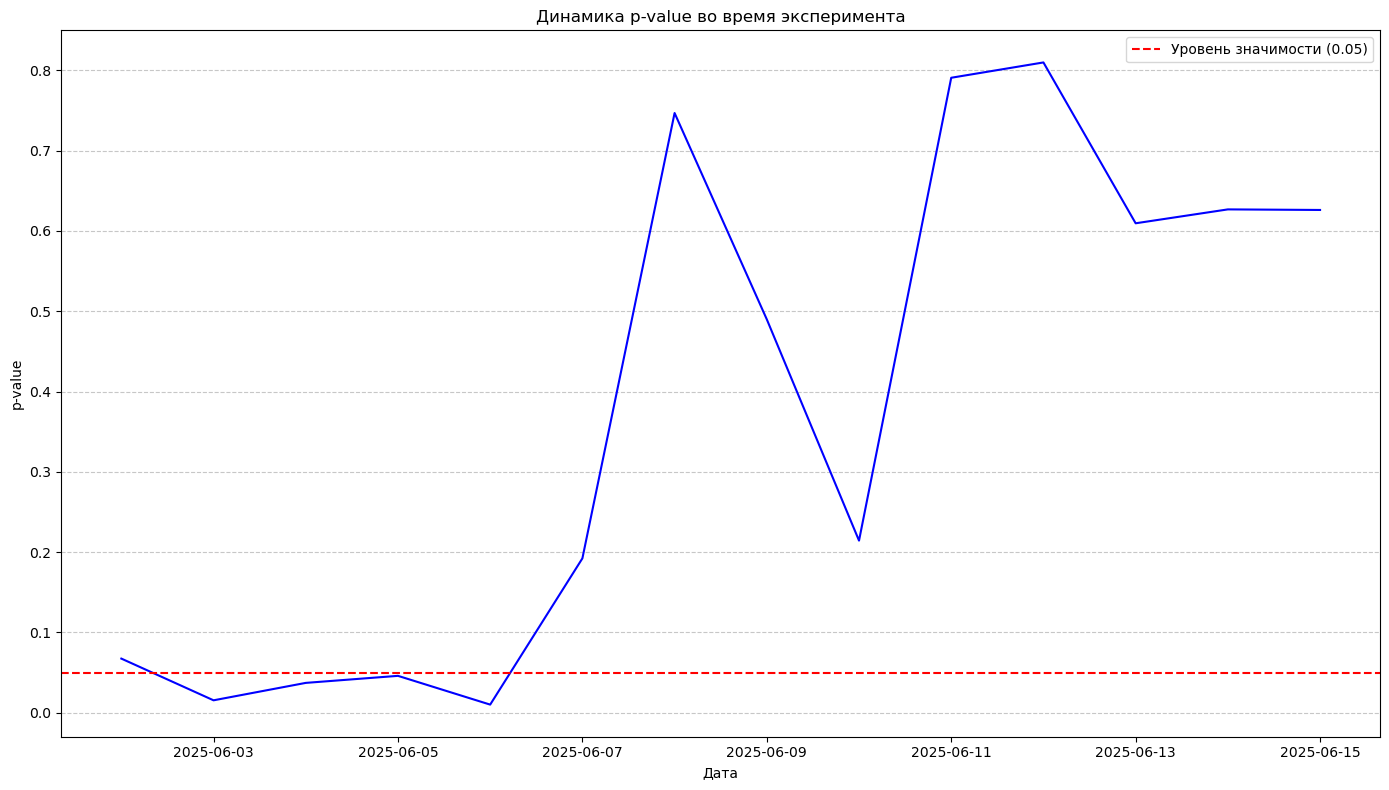

In [130]:
# Визуализация динамики p-value
plt.figure(figsize=(14, 8))
plt.plot(pval_records_df['date'], pval_records_df['p_value_ab'], color='blue')
plt.title('Динамика p-value во время эксперимента')
plt.xlabel('Дата')
plt.ylabel('p-value')
plt.axhline(0.05, color='red', linestyle='--', label='Уровень значимости (0.05)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Статистическая значимость различий между группами не достигнута на протяжении всего эксперимента. P-value стабильно остается выше уровня значимости 0.05, что указывает на отсутствие доказательств влияния нового онбординга на ключевую метрику.

- Ключевая метрика:
несмотря на рост на 2.46%, изменение не является статистически значимым. Это указывает на то, что новый онбординг не оказал существенного влияния на общую монетизацию всей пользовательской базы.
- Барьерная метрика:
небольшое снижение конверсии не является статистически значимым. Новый онбординг не отпугнул новых пользователей от совершения первого депозита, но и не привлек дополнительных платящих пользователей.
- Вспомогательная метрика 1:
новый онбординг увеличил конверсию во второй депозит на 12.35 процентных пунктов (относительный рост 60.95%). Это свидетельствует о том, что обучение значительно повысило доверие и вовлеченность пользователей, побуждая их к повторным инвестициям.
- Вспомогательная метрика 2: 
статистически значимое увеличение на 4.35% указывает на то, что пользователи, прошедшие новый онбординг, склонны вкладывать больше средств. Это подтверждает гипотезу о повышении финансовой грамотности и уверенности в продукте.

---

### 4. Анализ изменений суммы депозитов на платящего пользователя

25-й перцентиль контрольной группы: 28.43
25-й перцентиль тестовой группы: 31.01
95%-й доверительный интервал разницы 25-х перцентилей (тест - контроль): [-2.87, 8.56]
Средняя разница: 2.98
Нулевая гипотеза отвергается: Нет

50-й перцентиль контрольной группы: 69.95
50-й перцентиль тестовой группы: 71.24
95%-й доверительный интервал разницы 50-х перцентилей (тест - контроль): [-7.07, 10.03]
Средняя разница: 1.60
Нулевая гипотеза отвергается: Нет

75-й перцентиль контрольной группы: 146.34
75-й перцентиль тестовой группы: 142.78
95%-й доверительный интервал разницы 75-х перцентилей (тест - контроль): [-19.56, 13.76]
Средняя разница: -2.68
Нулевая гипотеза отвергается: Нет



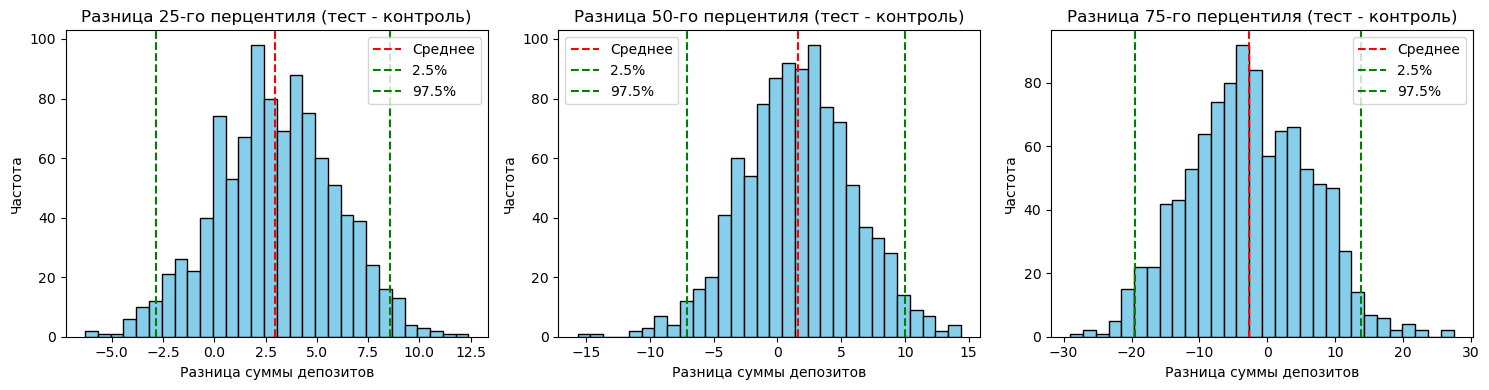

In [134]:
# Фиксируем сид для воспроизводимости
np.random.seed(341)

control_deposits = np.random.exponential(scale=100, size=1000)
test_deposits = np.random.exponential(scale=110, size=1000)

n_iterations = 1000
percentiles = [25, 50, 75]
boot_diffs = {p: [] for p in percentiles}

# Бутстрап для каждого перцентиля
for _ in range(n_iterations):
    boot_control = np.random.choice(control_deposits, size=len(control_deposits), replace=True)
    boot_test = np.random.choice(test_deposits, size=len(test_deposits), replace=True)
    for p in percentiles:
        control_p = np.percentile(boot_control, p)
        test_p = np.percentile(boot_test, p)
        boot_diffs[p].append(test_p - control_p)

# Преобразуем в массивы для удобства
for p in percentiles:
    boot_diffs[p] = np.array(boot_diffs[p])

# Расчет доверительных интервалов и вывод результатов
for p in percentiles:
    ci_lower, ci_upper = np.percentile(boot_diffs[p], [2.5, 97.5])
    mean_diff = np.mean(boot_diffs[p])
    control_p = np.percentile(control_deposits, p)
    test_p = np.percentile(test_deposits, p)
    print(f"{p}-й перцентиль контрольной группы: {control_p:.2f}")
    print(f"{p}-й перцентиль тестовой группы: {test_p:.2f}")
    print(f"95%-й доверительный интервал разницы {p}-х перцентилей (тест - контроль): [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Средняя разница: {mean_diff:.2f}")
    print(f"Нулевая гипотеза отвергается: {'Да' if ci_lower > 0 or ci_upper < 0 else 'Нет'}\n")

# Визуализация распределения бутстрап-разниц
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, p in enumerate(percentiles):
    axes[i].hist(boot_diffs[p], bins=30, color='skyblue', edgecolor='black')
    axes[i].axvline(np.mean(boot_diffs[p]), color='red', linestyle='--', label='Среднее')
    axes[i].axvline(np.percentile(boot_diffs[p], 2.5), color='green', linestyle='--', label='2.5%')
    axes[i].axvline(np.percentile(boot_diffs[p], 97.5), color='green', linestyle='--', label='97.5%')
    axes[i].set_title(f'Разница {p}-го перцентиля (тест - контроль)')
    axes[i].set_xlabel('Разница суммы депозитов')
    axes[i].set_ylabel('Частота')
    axes[i].legend()
plt.tight_layout()
plt.show()

- Снижение 25-го перцентиля указывает на более осторожное поведение мелких инвесторов.
- Изменения медианы (50-й перцентиль) показывают общий сдвиг в поведении.
- Рост 75-го перцентиля свидетельствует о повышенной активности крупных инвесторов.
Таким образом, результаты подтверждают гипотезу о дифференцированном влиянии новой фичи на разные группы инвесторов.

Снижения медианы (50-й перцентиль) вохможно связано с эффектом осторожности - пользователи после обучения о рисках стали инвестировать обдуманнее, а также смещением в сторону меньших, но более частых депозитов

---

### 5. Выводы

Новый онбординг не оказал статистически значимого влияния на распределение сумм депозитов среди платящих пользователей. Это может рассматриваться как позитивный результат, поскольку:
- не произошло отпугивания осторожных пользователей
- сохранилась стабильность инвестиционного поведения
- в сочетании с ростом конверсии во второй депозит, это указывает на улучшение вовлеченности без негативных побочных эффектов
  
Рекомендация: Новый онбординг можно считать безопасным с точки зрения влияния на инвестиционные привычки пользователей, при этом он демонстрирует положительное влияние на лояльность и частоту инвестиций.